# INITIALISATION OF COUNTRIES, ELO, LOCATION.

In [23]:
import random
import pandas as pd
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np


numtrials = 1000  

In [24]:
countries = [
    "Brazil",
    "Spain",
    "France",
    "Argentina",
    "Uruguay",
    "Colombia",
    "United Kingdom",
    "Paraguay",
    "Germany",
    "Ecuador",
    "Portugal",
    "Italy",
    "Morocco",
    "Egypt",
    "South Korea",
    "Japan",
    "Mexico",
    "Costa Rica",
    "New Zealand",
    "Australia",
]

poolsunbalanced = {
    1: ['Mexico', 'Costa Rica', 'Ecuador', 'Colombia'],
    2: ['Brazil', 'Paraguay', 'Uruguay', "Argentina"],
    3: ['South Korea', 'Japan', 'New Zealand', 'Australia'],
    4: ['United Kingdom', 'Germany', 'France', 'Italy', 'Spain', 'Portugal', 'Morocco', 'Egypt']
}

pools = {
    1: ['Mexico', 'Costa Rica', 'Ecuador', 'Colombia'],
    2: ['Brazil', 'Paraguay', 'Uruguay', "Argentina"],
    3: ['South Korea', 'Japan', 'New Zealand', 'Australia'],
    4: ['United Kingdom', 'Germany', 'France', 'Italy'],
    5: ['Spain', 'Portugal', 'Morocco', 'Egypt']
}


elo_ratings = [
    1994,
    2150,
    2031,
    2140,
    1922,
    1953,
    2012,
    1799,
    1988,
    1911,
    1988,
    1914,
    1807,
    1668,
    1745,
    1875,
    1817,
    1653,
    1596,
    1736,
]

def get_elo(name):
    return countriesratings[name]

countriesratings = {country: elo_ratings[countries.index(country)] for country in countries}
countries_ranked = sorted(countries, key=get_elo, reverse=True)

In [25]:
import folium
from IPython.display import display

locations = [
    (-14.2350, -51.9253),  # Brazil
    (40.4637, -3.7492),    # Spain
    (46.6034, 1.8883),     # France
    (-38.4161, -63.6167),  # Argentina
    (-32.5228, -55.7659),  # Uruguay
    (4.5709, -74.2973),    # Colombia
    (55.3781, -3.4360),    # United Kingdom
    (-23.4420, -58.4438),  # Paraguay
    (51.1657, 10.4515),    # Germany
    (-1.8312, -78.1834),   # Ecuador
    (39.3999, -8.2245),    # Portugal
    (41.8719, 12.5674),    # Italy
    (31.7915, -7.0926),    # Morocco
    (26.8206, 30.8025),    # Egypt
    (35.9078, 127.7669),   # South Korea
    (36.2048, 138.2529),   # Japan
    (23.6345, -102.5528),  # Mexico
    (9.7489, -83.7534),    # Costa Rica
    (-40.9006, 174.8860),  # New Zealand
    (-25.2744, 133.7751),   # Australia
]

locationdict = {country: locations[countries.index(country)] for country in countries}

games_played_country = {country: 0 for country in countries}
airtime_by_country = {country: 0 for country in countries}


# plot all countries on a map
m = folium.Map(location=[20, 20], zoom_start=2)
for name, rating, location in zip(countries, countriesratings.values(), locations):
    folium.Marker(
        location=location,
        icon=folium.Icon(color="red"),
        tooltip=f"{name} [{rating}]",
    ).add_to(m)
display(m)

# CALCULATING DISTANCE

In [26]:
from math import radians, sin, cos, sqrt, atan2

# DISTANCE CALCULATIONS
def haversine(pos1, pos2):
    lat1, lon1 = pos1
    lat2, lon2 = pos2
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6371.0 # Radius of Earth in kilometers
    return R * c # Distance in kilometers


def estimate_flight_time(pos1, pos2, speed_kmh=900):
    distance = haversine(pos1, pos2)
    time_hours = distance / speed_kmh
    return time_hours

# ELO SYSTEM + EVALUATION

In [27]:
# Elo system
def winrate(country1, country2):
    return (1/(1 + 10**((countriesratings[country2]-countriesratings[country1])/400)))

# Evaluation
def evaluate_ranking(ranking, true_ranking):
    """Determines how good a ranking is."""

    loss = 0

    # For each pair of countries in the ranking
    for i, A in enumerate(countries):
        for j, B in enumerate(countries):
            if i >= j:
                continue
            rank_A = ranking.index(A) + 1
            rank_B = ranking.index(B) + 1
            true_A = true_ranking.index(A) + 1
            true_B = true_ranking.index(B) + 1
            if (rank_A < rank_B) == (true_A < true_B):
                continue

            W = (
                1 / true_A
                + 1 / true_B
                + 1 / rank_A
                + 1 / rank_B
            )
            loss += W * (abs(0.5 - winrate(A, B)))
    return loss

# MATCH SIMULATION

In [28]:
def simulate_match(country1, country2):
    
    global totaltime
    totaltime += 2*estimate_flight_time(locationdict[country1], locationdict[country2])
    
    global total_games_played
    total_games_played += 1
    
    games_played_country[country1] += 1
    games_played_country[country2] += 1
    
    result_country = random.choice([country1, country2])
    airtime_by_country[result_country] += 2*estimate_flight_time(locationdict[country1], locationdict[country2])
    
    percent1 = winrate(country1, country2)
    
    if random.random() < percent1:
        result = 'win'
    else:
        result = 'loss'
    
    if result == 'win':
        return country1, 3, country2, 0  # country1 wins, gets 3 points, country2 gets 0
    elif result == 'loss':
        return country1, 0, country2, 3  # country2 wins, gets 3 points, country1 gets 0
    else:
        return country1, 1, country2, 1  # Draw, both get 1 point each

In [29]:
def init_standings(teams):
    return {team: {'wins': 0, 'losses': 0, 'draws': 0, 'points': 0} for team in teams}

def sort_standings(standings):
    df = pd.DataFrame(standings).T
    df = df.sort_values(by=['points', 'wins'], ascending=False)
    return df

# TOURNAMENT SIMULATIONS

In [30]:
def round_robin(teams):
    standings = init_standings(teams)
    for team1, team2 in combinations(teams, 2):
        t1, p1, t2, p2 = simulate_match(team1, team2)
        standings[t1]['points'] += p1
        standings[t2]['points'] += p2
        if p1 == 3:
            standings[t1]['wins'] += 1
            standings[t2]['losses'] += 1
        elif p2 == 3:
            standings[t2]['wins'] += 1
            standings[t1]['losses'] += 1
        else:
            standings[t1]['draws'] += 1
            standings[t2]['draws'] += 1
    return standings

In [31]:
def simulate_knockout(teams):
    seeded = []
    
    for country in teams:
        seeded.append((country, countriesratings[country]))
    
    seeded.sort(key=lambda x: x[1], reverse=True)
    quarter_finalists = [seeded[0][0], seeded[7][0], seeded[3][0], seeded[4][0], seeded[1][0], seeded[6][0], seeded[2][0], seeded[5][0]]
    semi_finalists = []
    bottom4 = []
    thirdfourth = []
    

    # Quarterfinals
    for i in range(0, 8, 2):
        team1, team2 = quarter_finalists[i], quarter_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < winrate(team1, team2) else 2]
        semi_finalists.append(winner)
        if winner != team1:
            bottom4.append(team1)
        else:
            bottom4.append(team2)
    
    # Sort bottom4 based on the order they appear in the list seeded
    bottom4.sort(key=lambda x: next(i for i, v in enumerate(seeded) if v[0] == x))

    # Semifinals
    finalists = []
    for i in range(0, 4, 2):
        team1, team2 = semi_finalists[i], semi_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < winrate(team1, team2) else 2]
        finalists.append(winner)
        if winner != team1:
            thirdfourth.append(team1)
        else:
            thirdfourth.append(team2)
    thirdfourth.sort(key=lambda x: next(i for i, v in enumerate(seeded) if v[0] == x))
    

    # Final
    final_winner = simulate_match(finalists[0], finalists[1])[0 if random.random() < winrate(team1, team2) else 2]
    if final_winner != finalists[0]:
        second = finalists[0]
    else:
        second = finalists[1]
    
    return {
        bottom4[0]: 5,
        bottom4[1]: 6,
        bottom4[2]: 7,
        bottom4[3]: 8,
        thirdfourth[0]: 3,
        thirdfourth[1]: 4,
        second: 2,
        final_winner: 1
    }

# PLOTTING

In [32]:
# ---------------------------- PLOTTING ---------------------------------
# Calculate rankings based on countriesratings
def plotgraph(avgstandings, title):
    ratings_ranking = {country: rank for rank, country in enumerate(sorted(countriesratings, key=countriesratings.get, reverse=True), start=1)}


    # Prepare data for the bar graph
    avg_standings_values = [avgstandings[country] for country in countries]

    # Perform max-min normalization for ratings
    min_avg_standing = min(avg_standings_values)
    max_avg_standing = max(avg_standings_values)

    normalized_ratings = {
        country: max_avg_standing - ((max_avg_standing - min_avg_standing) * (countriesratings[country] - min(countriesratings.values())) / 
                                    (max(countriesratings.values()) - min(countriesratings.values())))
        for country in countries
    }

    ratings_ranking_values = [normalized_ratings[country] for country in countries]



    x = np.arange(len(countries))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, avg_standings_values, width, label='Average Standing')
    rects2 = ax.bar(x + width/2, ratings_ranking_values, width, label='Ratings Ranking')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Countries')
    ax.set_ylabel('Rankings')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(countries, rotation=45, ha='right')
    ax.legend()
    fig.tight_layout()

    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.show()

# SPECIFIC MODELS

## Full Single Round Robin

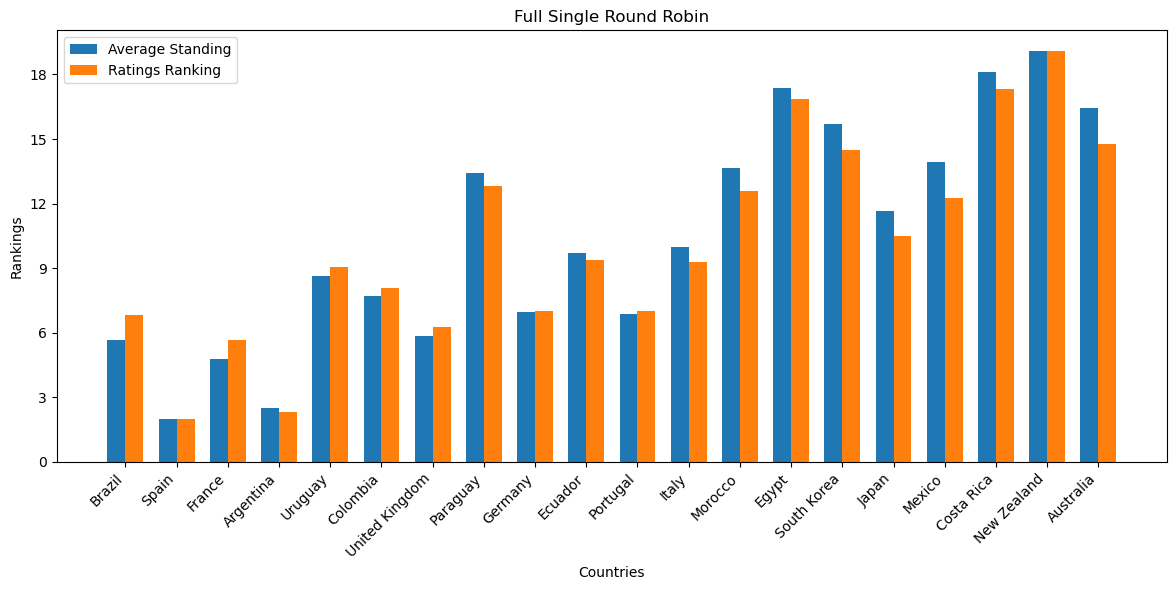

Total games played: 190.0
Total time: 3783.631853494826 hours
{'Brazil': 19.0, 'Spain': 19.0, 'France': 19.0, 'Argentina': 19.0, 'Uruguay': 19.0, 'Colombia': 19.0, 'United Kingdom': 19.0, 'Paraguay': 19.0, 'Germany': 19.0, 'Ecuador': 19.0, 'Portugal': 19.0, 'Italy': 19.0, 'Morocco': 19.0, 'Egypt': 19.0, 'South Korea': 19.0, 'Japan': 19.0, 'Mexico': 19.0, 'Costa Rica': 19.0, 'New Zealand': 19.0, 'Australia': 19.0}
Average Loss: 1.4987220769886314
Standard Deviation of number of games played: 0.0
Standard Deviation of airtime of countries: 66.40272499676557


In [33]:
import statistics
avgstandings = {country: 0 for country in countries}

fits = {}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for i in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    standings = round_robin(countries)
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x]['points'], reverse=True)
    
    for j in range(len(sorted_countries)):
        avgstandings[sorted_countries[j]] += (j+1)
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
    total_std += statistics.stdev(airtime_by_country.values())
    
for country, ranking in avgstandings.items():
    avgstandings[country] = ranking/numtrials

airtime_std = total_std/numtrials

# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Full Single Round Robin')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")

std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['fullsinglerobin'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}

## Full Double Round Robin

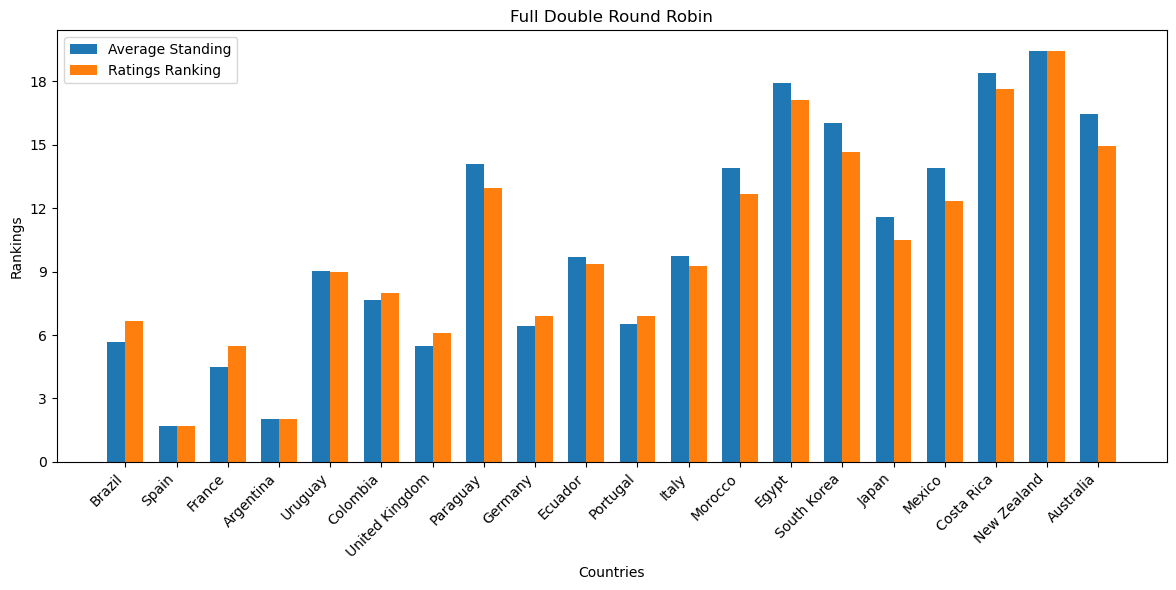

Total games played: 380.0
Total time: 7567.263706988787 hours
{'Brazil': 38.0, 'Spain': 38.0, 'France': 38.0, 'Argentina': 38.0, 'Uruguay': 38.0, 'Colombia': 38.0, 'United Kingdom': 38.0, 'Paraguay': 38.0, 'Germany': 38.0, 'Ecuador': 38.0, 'Portugal': 38.0, 'Italy': 38.0, 'Morocco': 38.0, 'Egypt': 38.0, 'South Korea': 38.0, 'Japan': 38.0, 'Mexico': 38.0, 'Costa Rica': 38.0, 'New Zealand': 38.0, 'Australia': 38.0}
Average Loss: 0.8510974444699616
Standard Deviation of number of games played: 0.0
Standard Deviation of airtime of countries: 110.54465536171742


In [34]:
avgstandings = {country: 0 for country in countries}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for i in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    standings = round_robin(countries)
    standings2 = round_robin(countries)
    
    for country in standings:
        standings[country]['points'] += standings2[country]['points']
        standings[country]['wins'] += standings2[country]['wins']
        standings[country]['losses'] += standings2[country]['losses']
        standings[country]['draws'] += standings2[country]['draws']
    
    
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x]['points'], reverse=True)
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
    
    for j in range(len(sorted_countries)):
        avgstandings[sorted_countries[j]] += (j+1)
    
    total_std += statistics.stdev(airtime_by_country.values())
        
    
for country, ranking in avgstandings.items():
    avgstandings[country] = ranking/numtrials
    
airtime_std = total_std/numtrials
    
# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Full Double Round Robin')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")

std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['fulldoublerobin'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}

## Single Round Robin: Unbalanced Groups

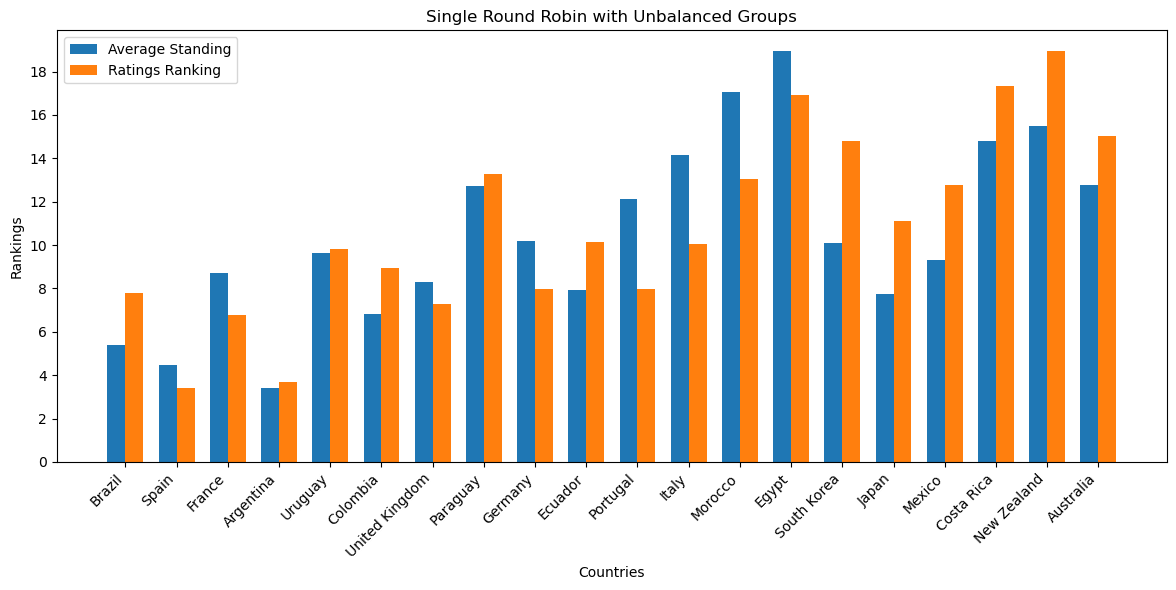

Total games played: 109.0
Total time: 1525.0076152973268 hours
{'Brazil': 8.769, 'Spain': 13.176, 'France': 13.624, 'Argentina': 9.071, 'Uruguay': 9.86, 'Colombia': 8.807, 'United Kingdom': 13.657, 'Paraguay': 9.877, 'Germany': 13.628, 'Ecuador': 8.725, 'Portugal': 14.145, 'Italy': 13.952, 'Morocco': 14.003, 'Egypt': 14.0, 'South Korea': 7.918, 'Japan': 7.401, 'Mexico': 8.494, 'Costa Rica': 9.68, 'New Zealand': 9.816, 'Australia': 9.397}
Average Loss: 5.5564646469753045
Standard Deviation of number of games played: 2.4889138827587978
Standard Deviation of airtime of countries: 45.29576683637668


In [35]:
avgstandings = {country: 0 for country in countries}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for _ in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    pool_results = {}
    direct_to_quarters = []
    qualifier_candidates = []
    bottom8 = []
    ninthtwelve = []

    # ---------- Phase 1: Group Roundrobin ----------
    for pool_name, teams in poolsunbalanced.items():
            
        standings = round_robin(teams)
        df = sort_standings(standings)
        pool_results[pool_name] = df
        direct_to_quarters.append(df.index[0])            # Top 1 to quarters
        qualifier_candidates.extend(df.index[1:3]) 
        
        if len(teams) == 4:
            bottom8.append(df.index[3])
        else:
            bottom8.extend(df.index[3:8])

    # ---------- Phase 2: Qualifiers: Next 8 teams run in qualifiers ----------
    qualifier_results = round_robin(qualifier_candidates)
    qualifier_df = sort_standings(qualifier_results)
    qualifier_top4 = list(qualifier_df.index[:4])
    ninthtwelve.extend(qualifier_df.index[4:])

    # ---------- Phase 3: Knockout ----------
    knockout_teams = direct_to_quarters + qualifier_top4
    knockout_results = simulate_knockout(knockout_teams)

    # ---------- Phase 4: Placement Round ----------
    placement_results = round_robin(bottom8)
    placement_df = sort_standings(placement_results)

    sorted_placement = sorted(placement_results.keys(), key=lambda x: placement_results[x]['points'], reverse=True)

    standings = init_standings(countries)

    rank = 13
    for country in sorted_placement:
        standings[country] = rank
        rank += 1

    sorted_knockout = sorted(knockout_results.items(), key=lambda x: x[1])
    for country, position in sorted_knockout:
        standings[country] = position
        
    rank = 9
    for country in ninthtwelve:
        standings[country] = rank
        rank += 1
        
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x])
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
    
    for country, position in standings.items():
        avgstandings[country] += position
        
    total_std += statistics.stdev(airtime_by_country.values())
        
for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials

airtime_std = total_std/numtrials

# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Single Round Robin with Unbalanced Groups')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")
std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['singlerobinunbalanced'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}


## Double Round Robin: Unbalanced Groups

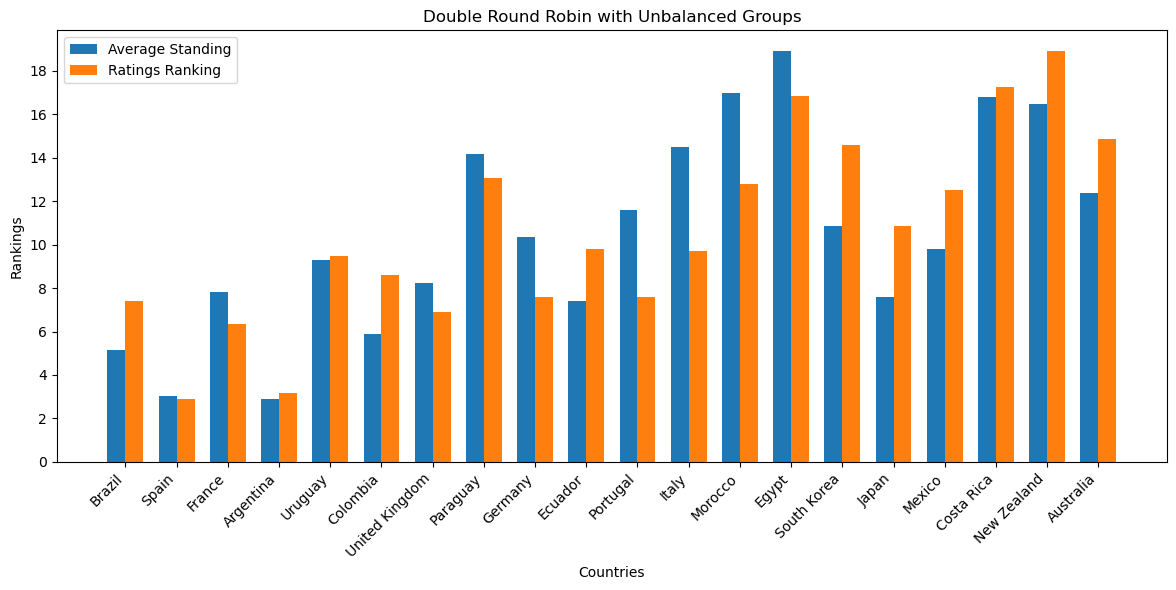

Total games played: 211.0
Total time: 2920.7338366296312 hours
{'Brazil': 17.478, 'Spain': 22.172, 'France': 26.707, 'Argentina': 13.897, 'Uruguay': 19.259, 'Colombia': 15.562, 'United Kingdom': 27.097, 'Paraguay': 19.907, 'Germany': 27.637, 'Ecuador': 15.631, 'Portugal': 27.885, 'Italy': 27.949, 'Morocco': 28.001, 'Egypt': 28.0, 'South Korea': 16.949, 'Japan': 11.994, 'Mexico': 17.624, 'Costa Rica': 19.819, 'New Zealand': 19.897, 'Australia': 18.535}
Average Loss: 4.174867607584941
Standard Deviation of number of games played: 5.388862168740653
Standard Deviation of airtime of countries: 81.37279558353937


In [36]:
avgstandings = {country: 0 for country in countries}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for _ in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    pool_results = {}
    direct_to_quarters = []
    qualifier_candidates = []
    bottom8 = []
    ninthtwelve = []

    # ---------- Phase 1: Group Roundrobin ----------
    for pool_name, teams in poolsunbalanced.items():
            
        standings = round_robin(teams)
        standings2 = round_robin(teams)
        
        for country in standings:
            standings[country]['points'] += standings2[country]['points']
            standings[country]['wins'] += standings2[country]['wins']
            standings[country]['losses'] += standings2[country]['losses']
            standings[country]['draws'] += standings2[country]['draws']
        
        df = sort_standings(standings)
        pool_results[pool_name] = df
        direct_to_quarters.append(df.index[0])      # Top 1 to quarters
        qualifier_candidates.extend(df.index[1:3]) 
        
        if len(teams) == 4:
            bottom8.append(df.index[3])
        else:
            bottom8.extend(df.index[3:8])
            

    # ---------- Phase 2: Qualifiers: Next 8 teams run in qualifiers ----------
    qualifier_results = round_robin(qualifier_candidates)
    qualifer2 = round_robin(qualifier_candidates)
    for country in qualifier_results:
        qualifier_results[country]['points'] += qualifer2[country]['points']
        qualifier_results[country]['wins'] += qualifer2[country]['wins']
        qualifier_results[country]['losses'] += qualifer2[country]['losses']
        qualifier_results[country]['draws'] += qualifer2[country]['draws']
    qualifier_df = sort_standings(qualifier_results)
    qualifier_top4 = list(qualifier_df.index[:4])
    ninthtwelve.extend(qualifier_df.index[4:])

    # ---------- Phase 3: Knockout ----------
    knockout_teams = direct_to_quarters + qualifier_top4
    knockout_results = simulate_knockout(knockout_teams)
    
    # ---------- Phase 4: Placement Round ----------
    placement_results = round_robin(bottom8)
    placement2 = round_robin(bottom8)
    for country in placement_results:
        placement_results[country]['points'] += placement2[country]['points']
        placement_results[country]['wins'] += placement2[country]['wins']
        placement_results[country]['losses'] += placement2[country]['losses']
        placement_results[country]['draws'] += placement2[country]['draws']
    placement_df = sort_standings(placement_results)
    
    
    sorted_placement = sorted(placement_results.keys(), key=lambda x: placement_results[x]['points'], reverse=True)
    standings = init_standings(countries)

    rank = 13
    for country in sorted_placement:
        standings[country] = rank
        rank += 1

    sorted_knockout = sorted(knockout_results.items(), key=lambda x: x[1])
    for country, position in sorted_knockout:
        standings[country] = position
        
    rank = 9
    for country in ninthtwelve:
        standings[country] = rank
        rank += 1
        
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x])
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
        
    for country, position in standings.items():
        avgstandings[country] += position
    
    total_std += statistics.stdev(airtime_by_country.values())
        
for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials
    
airtime_std = total_std/numtrials
    
# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Double Round Robin with Unbalanced Groups')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")
std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['doublerobinunbalanced'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}

## Single Round Robin, 5 groups of 4

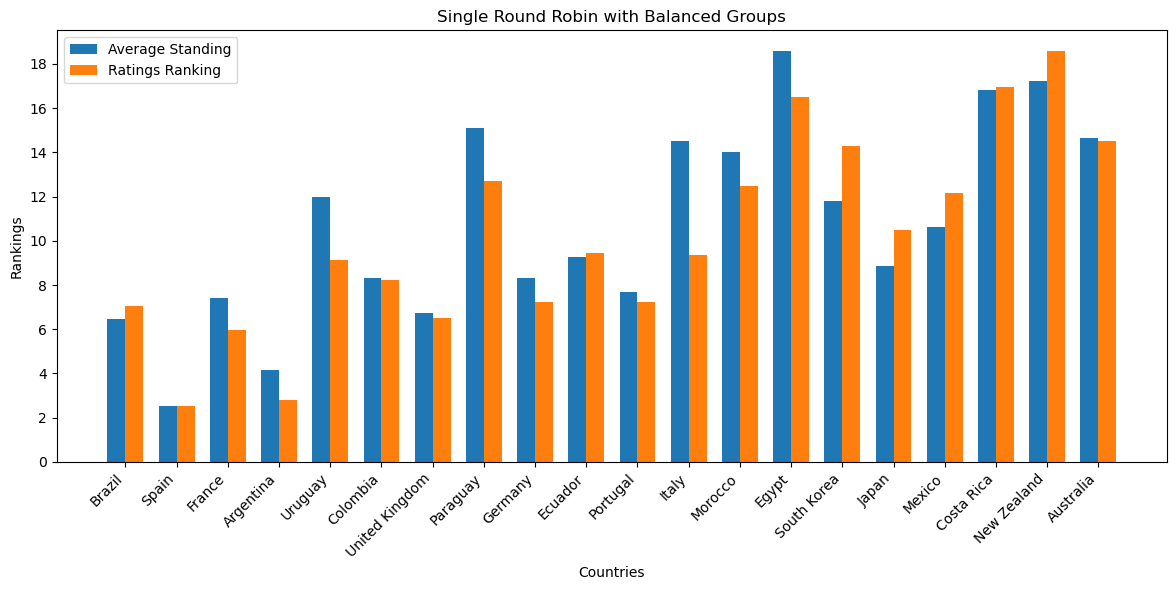

Total games played: 92.0
Total time: 1463.8785339342874 hours
{'Brazil': 9.417, 'Spain': 7.313, 'France': 10.235, 'Argentina': 9.543, 'Uruguay': 9.6, 'Colombia': 9.492, 'United Kingdom': 8.569, 'Paraguay': 9.161, 'Germany': 9.892, 'Ecuador': 8.838, 'Portugal': 11.027, 'Italy': 8.81, 'Morocco': 10.736, 'Egypt': 8.277, 'South Korea': 8.751, 'Japan': 8.048, 'Mexico': 9.186, 'Costa Rica': 8.603, 'New Zealand': 9.223, 'Australia': 9.279}
Average Loss: 3.8853311212957373
Standard Deviation of number of games played: 0.877943769929427
Standard Deviation of airtime of countries: 51.30930215746277


In [37]:
avgstandings = {country: 0 for country in countries}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for _ in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    pool_results = {}
    direct_to_quarters = []
    qualifier_candidates = []
    bottom4 = []
    ninth16 = []

    # ---------- Phase 1: Group Roundrobin ----------
    for pool_name, teams in pools.items():
            
        standings = round_robin(teams)
        df = sort_standings(standings)
        pool_results[pool_name] = df
        direct_to_quarters.append(df.index[0])      # Top 1 to quarters
        qualifier_candidates.extend(df.index[1:3]) 
        
        bottom4.append(df.index[3])
            

    # ---------- Phase 2: Qualifiers: Next 10 teams run in qualifiers ----------
    qualifier_results = round_robin(qualifier_candidates)
    qualifier_df = sort_standings(qualifier_results)
    qualifier_top4 = list(qualifier_df.index[:3])
    ninth16.extend(qualifier_df.index[3:])

    # ---------- Phase 3: Knockout ----------
    knockout_teams = direct_to_quarters + qualifier_top4
    knockout_results = simulate_knockout(knockout_teams)
    
    # ---------- Phase 4: Placement Round ----------
    placement_results = round_robin(bottom4)
    placement_df = sort_standings(placement_results)
    
    
    sorted_placement = sorted(placement_results.keys(), key=lambda x: placement_results[x]['points'], reverse=True)
    standings = init_standings(countries)

    rank = 17
    for country in sorted_placement:
        standings[country] = rank
        rank += 1

    sorted_knockout = sorted(knockout_results.items(), key=lambda x: x[1])
    for country, position in sorted_knockout:
        standings[country] = position
        
    rank = 9
    for country in ninth16:
        standings[country] = rank
        rank += 1
        
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x])
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
        
    for country, position in standings.items():
        avgstandings[country] += position

    # Calculate standard deviation of flight times
    total_std += statistics.stdev(airtime_by_country.values())
        
for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials

airtime_std = total_std/numtrials

# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Single Round Robin with Balanced Groups')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")
std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['singlerobinbalanced'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}

## Double Round Robin: 5 Groups of 4

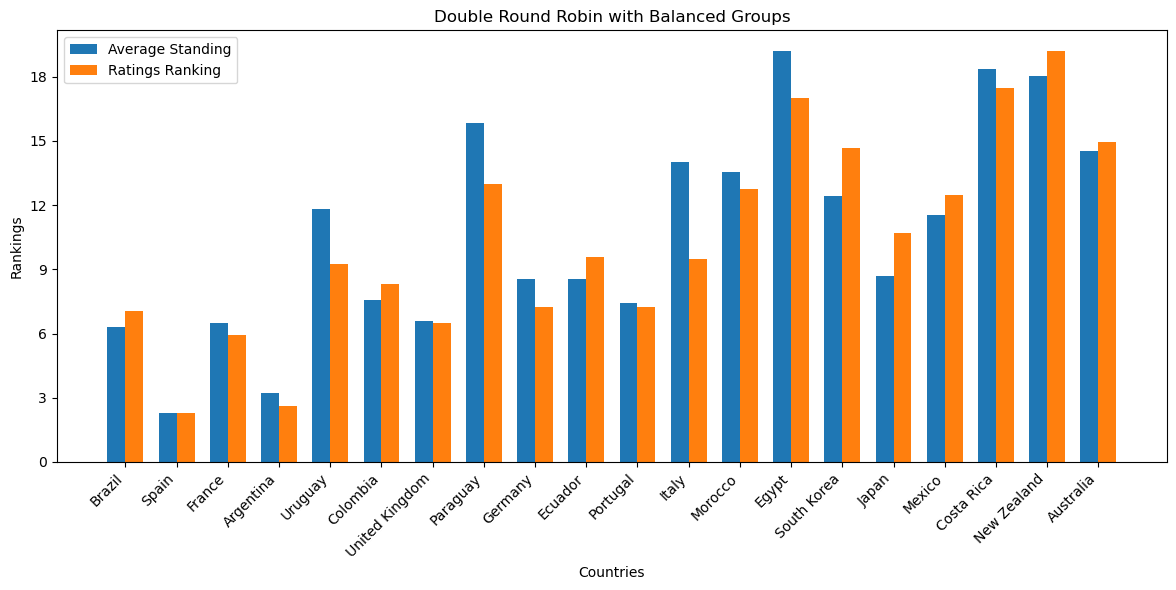

Total games played: 177.0
Total time: 2795.697765356699 hours
{'Brazil': 19.622, 'Spain': 10.507, 'France': 18.872, 'Argentina': 14.719, 'Uruguay': 19.652, 'Colombia': 17.335, 'United Kingdom': 16.915, 'Paraguay': 17.806, 'Germany': 18.352, 'Ecuador': 16.798, 'Portugal': 22.932, 'Italy': 17.517, 'Morocco': 22.487, 'Egypt': 15.433, 'South Korea': 18.446, 'Japan': 13.892, 'Mexico': 19.87, 'Costa Rica': 15.949, 'New Zealand': 17.424, 'Australia': 19.472}
Average Loss: 3.0652927130343093
Standard Deviation of number of games played: 2.837840060772685
Standard Deviation of airtime of countries: 95.53635020139845


In [38]:
avgstandings = {country: 0 for country in countries}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for _ in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    sorted_countries = []
    
    pool_results = {}
    direct_to_quarters = []
    qualifier_candidates = []
    bottom4 = []
    ninth16 = []

    # ---------- Phase 1: Group Roundrobin ----------
    for pool_name, teams in pools.items():
            
        standings = round_robin(teams)
        standings2 = round_robin(teams)
        
        for country in standings:
            standings[country]['points'] += standings2[country]['points']
            standings[country]['wins'] += standings2[country]['wins']
            standings[country]['losses'] += standings2[country]['losses']
            standings[country]['draws'] += standings2[country]['draws']
        
        df = sort_standings(standings)
        pool_results[pool_name] = df
        direct_to_quarters.append(df.index[0])      # Top 1 to quarters
        qualifier_candidates.extend(df.index[1:3]) 
        
        bottom4.append(df.index[3])
            

    # ---------- Phase 2: Qualifiers: Next 10 teams run in qualifiers ----------
    qualifier_results = round_robin(qualifier_candidates)
    qualifer2 = round_robin(qualifier_candidates)
    for country in qualifier_results:
        qualifier_results[country]['points'] += qualifer2[country]['points']
        qualifier_results[country]['wins'] += qualifer2[country]['wins']
        qualifier_results[country]['losses'] += qualifer2[country]['losses']
        qualifier_results[country]['draws'] += qualifer2[country]['draws']
    qualifier_df = sort_standings(qualifier_results)
    qualifier_top4 = list(qualifier_df.index[:3])
    ninth16.extend(qualifier_df.index[3:])

    # ---------- Phase 3: Knockout ----------
    knockout_teams = direct_to_quarters + qualifier_top4
    knockout_results = simulate_knockout(knockout_teams)
    
    # ---------- Phase 4: Placement Round ----------
    placement_results = round_robin(bottom4)
    placement2 = round_robin(bottom4)
    for country in placement_results:
        placement_results[country]['points'] += placement2[country]['points']
        placement_results[country]['wins'] += placement2[country]['wins']
        placement_results[country]['losses'] += placement2[country]['losses']
        placement_results[country]['draws'] += placement2[country]['draws']
    placement_df = sort_standings(placement_results)
    
    
    sorted_placement = sorted(placement_results.keys(), key=lambda x: placement_results[x]['points'], reverse=True)
    standings = init_standings(countries)

    rank = 17
    for country in sorted_placement:
        standings[country] = rank
        rank += 1

    sorted_knockout = sorted(knockout_results.items(), key=lambda x: x[1])
    for country, position in sorted_knockout:
        standings[country] = position
        
    rank = 9
    for country in ninth16:
        standings[country] = rank
        rank += 1
        
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x])
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
        
    for country, position in standings.items():
        avgstandings[country] += position
        
    total_std += statistics.stdev(airtime_by_country.values())
        
for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials
    
airtime_std = total_std/numtrials
    
# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Double Round Robin with Balanced Groups')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")
std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['doublerobinbalanced'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}

## Random Elimination

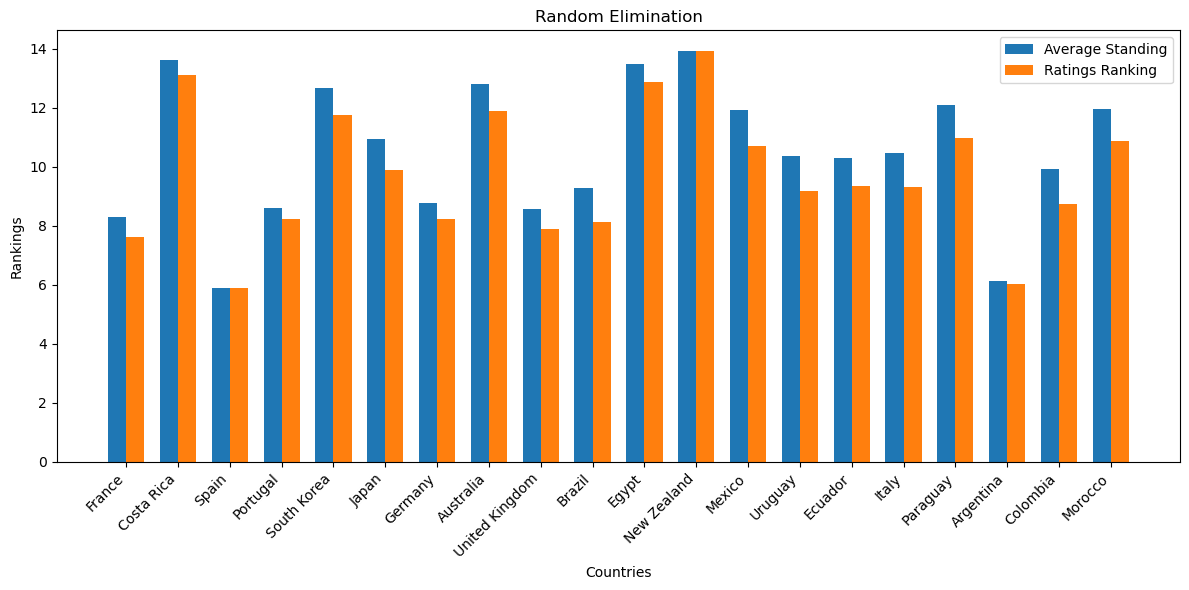

Total games played: 19.0
Total time: 351.08788149060734 hours
{'Brazil': 2.146, 'Spain': 2.996, 'France': 2.367, 'Argentina': 2.969, 'Uruguay': 1.888, 'Colombia': 2.003, 'United Kingdom': 2.308, 'Paraguay': 1.536, 'Germany': 2.261, 'Ecuador': 1.886, 'Portugal': 2.263, 'Italy': 1.883, 'Morocco': 1.544, 'Egypt': 1.29, 'South Korea': 1.425, 'Japan': 1.764, 'Mexico': 1.596, 'Costa Rica': 1.277, 'New Zealand': 1.194, 'Australia': 1.404}
Average Loss: 7.860131424326797
Standard Deviation of number of games played: 0.5212749552274388
Standard Deviation of airtime of countries: 19.054771392476606


In [39]:
import random

def simulate_random_elimination(countries):
    # Initialize standings
    standings = {country: 0 for country in countries}
    eliminated = []

    # Random elimination rounds
    round_number = 1
    while len(countries) > 1:
        random.shuffle(countries)
        next_round = []

        for i in range(0, len(countries), 2):
            if i + 1 < len(countries):
                country1 = countries[i]
                country2 = countries[i + 1]
                t1, p1, t2, p2 = simulate_match(country1, country2)
                
                if p1 == 3:
                    # country1 won
                    winner = t1
                else:
                    winner = t2
        
                loser = country1 if winner == country2 else country2
                next_round.append(winner)
                eliminated.append(loser)
            else:
                # If odd number of countries, the last one automatically advances
                next_round.append(countries[i])

        countries = next_round
        round_number += 1

    # Final winner
    winner = countries[0]
    standings[winner] = 1

    # Assign rankings to eliminated countries
    rank = 2
    for country in reversed(eliminated):
        standings[country] = rank
        rank += 1

    return standings

# Simulate the random elimination system
avgstandings = {country: 0 for country in countries}
loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for _ in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    random_elimination_standings = simulate_random_elimination(countries)
    
    sorted_countries = sorted(random_elimination_standings.keys(), key=lambda x: random_elimination_standings[x])
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
    
    for country, position in random_elimination_standings.items():
        avgstandings[country] += position
        
    total_std += statistics.stdev(airtime_by_country.values())
    
for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials

airtime_std = total_std/numtrials    

# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Random Elimination')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")
std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['elimination'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}
    


# ANALYSIS

In [ ]:

normalized_fits = {}
metrics = ['games', 'time', 'deviation', 'loss', 'airtimedev']



# Extract min and max
min_max = {metric: (min(fit[metric] for fit in fits.values()), max(fit[metric] for fit in fits.values())) for metric in metrics}

# Normalize
for key, values in fits.items():
    normalized_fits[key] = {
        metric: (values[metric] - min_max[metric][0]) / (min_max[metric][1] - min_max[metric][0])
        for metric in metrics
    }

# weights = [0.1968708483,	0.2797103175,	0.0807229401,	0.442695894]
# weights = [0.2214610339,	0.3101115125,	0.07330141242,	0.3951260413]

weights = [0.2104155797,	0.3404226382,	0.07273615894,	0.2821103089,	0.0943153142]
perturbance = 0.1

# Sensitivity analysis
sensitivity_results = {}

for i, original_weight in enumerate(weights):
    perturbed_weights = weights.copy()
    
    # Increase
    perturbed_weights[i] = original_weight * (1+perturbance)
    increased_index = {}
    for key, values in normalized_fits.items():
        increased_index[key] = 1 - sum(values[metric] * weight for metric, weight in zip(metrics, perturbed_weights))
    
    # Decrease
    perturbed_weights[i] = original_weight * (1-perturbance)
    decreased_index = {}
    for key, values in normalized_fits.items():
        decreased_index[key] = 1 - sum(values[metric] * weight for metric, weight in zip(metrics, perturbed_weights))
    
    sensitivity_results[metrics[i]] = {
        "increased": increased_index,
        "decreased": decreased_index
    }

for metric, result in sensitivity_results.items():
    print(f"Sensitivity analysis for {metric}:")
    print("Increased weight:")
    for mode, index in result["increased"].items():
        print(f"  {mode}: {index:.3f}")
    print("Decreased weight:")
    for mode, index in result["decreased"].items():
        print(f"  {mode}: {index:.3f}")
    print()

# Overall index
overall_index = {}
for key, values in normalized_fits.items():
    overall_index[key] = 1 - sum(values[metric] * weight for metric, weight in zip(metrics, weights))
  
for mode, index in overall_index.items():
    print(mode, index)



Sensitivity analysis for games:
Increased weight:
  fullsinglerobin: 0.695
  fulldoublerobin: 0.428
  singlerobinunbalanced: 0.628
  doublerobinunbalanced: 0.518
  singlerobinbalanced: 0.718
  doublerobinbalanced: 0.609
  elimination: 0.617
Decreased weight:
  fullsinglerobin: 0.715
  fulldoublerobin: 0.470
  singlerobinunbalanced: 0.639
  doublerobinunbalanced: 0.540
  singlerobinbalanced: 0.727
  doublerobinbalanced: 0.628
  elimination: 0.617

Sensitivity analysis for time:
Increased weight:
  fullsinglerobin: 0.689
  fulldoublerobin: 0.415
  singlerobinunbalanced: 0.628
  doublerobinunbalanced: 0.517
  singlerobinbalanced: 0.717
  doublerobinbalanced: 0.607
  elimination: 0.617
Decreased weight:
  fullsinglerobin: 0.722
  fulldoublerobin: 0.483
  singlerobinunbalanced: 0.639
  doublerobinunbalanced: 0.541
  singlerobinbalanced: 0.728
  doublerobinbalanced: 0.630
  elimination: 0.617

Sensitivity analysis for deviation:
Increased weight:
  fullsinglerobin: 0.705
  fulldoublerobin: 0